# Task
Train a lightweight image classification model using TensorFlow Lite for recognizing recyclable items using the dataset provided in "/content/waste.zip". Convert the model to TensorFlow Lite, test it, and explain the benefits of Edge AI for real-time applications. Deliverables: Code and a report with accuracy metrics and deployment steps.

## Data loading and preprocessing

### Subtask:
Load and preprocess the image dataset from "/content/waste.zip". This will involve extracting the zip file, organizing the data, and preparing it for use with TensorFlow.


**Reasoning**:
Extract the zip file containing the image dataset and load the training and validation datasets using `image_dataset_from_directory`.



In [7]:
import zipfile
import os
import tensorflow as tf

# Create a directory to extract the zip file
extract_dir = '/content/waste'
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile('/content/waste.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define the path to the extracted dataset
dataset_dir = os.path.join(extract_dir, 'waste') # Assuming the zip contains a 'waste' folder

# Load the training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

Found 15000 files belonging to 1 classes.
Using 12000 files for training.
Found 15000 files belonging to 1 classes.
Using 3000 files for validation.
Class names: ['images']
Number of classes: 1


**Reasoning**:
The dataset loading seems to have a problem as it found only 1 class instead of 30. This is likely due to how the data is organized within the zip file. Need to inspect the extracted directory structure to correctly load the data.



In [8]:
# Inspect the directory structure
!ls -l /content/waste/waste

# Re-attempt loading the dataset after inspecting the structure
# Assuming the subdirectories containing images for each class are directly under /content/waste/waste
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the class names again
class_names = train_ds.class_names
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

total 8
drwxr-xr-x 3 root root 4096 Jul 24 12:50 images
-rw-r--r-- 1 root root 2775 Jul 24 13:59 README.txt
Found 15000 files belonging to 1 classes.
Using 12000 files for training.
Found 15000 files belonging to 1 classes.
Using 3000 files for validation.
Class names: ['images']
Number of classes: 1


**Reasoning**:
The previous attempt to load the dataset still resulted in only one class being found. The directory listing shows a single 'images' directory under `/content/waste/waste`. This indicates that the actual class subdirectories are likely within this 'images' directory. I need to adjust the `dataset_dir` to point to `/content/waste/waste/images` to correctly load the data based on the subdirectories within 'images'. After correcting the path, I will apply a simple normalization preprocessing step to the datasets.



In [9]:
# Correct the dataset directory to point to the 'images' folder
dataset_dir_corrected = os.path.join(dataset_dir, 'images')

# Load the training and validation datasets with the corrected path
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_corrected,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_corrected,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the class names again
class_names = train_ds.class_names
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Apply normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 1 classes.
Using 12000 files for training.
Found 15000 files belonging to 1 classes.
Using 3000 files for validation.
Class names: ['images']
Number of classes: 1


## Data loading and preprocessing

### Subtask:
Load and preprocess the image dataset from "/content/waste.zip". This will involve extracting the zip file, organizing the data, and preparing it for use with TensorFlow.


**Reasoning**:
The previous attempts to load the dataset using `tf.keras.utils.image_dataset_from_directory` failed because the function only detected one class. This likely means the directory structure was not as expected (class subdirectories directly under the provided path). To proceed, I need to understand the actual directory structure within the `images` folder to correctly point `image_dataset_from_directory` to the location containing the class folders. I will list the contents of `/content/waste/waste/images` to verify the structure.



In [10]:
# List the contents of the 'images' directory
!ls -l /content/waste/waste/images

total 4
drwxr-xr-x 32 root root 4096 Jul 24 12:50 images


**Reasoning**:
The previous `ls -l` command showed that the `/content/waste/waste/images` directory *itself* contains another directory also named `images`. This is unexpected and likely the reason why `image_dataset_from_directory` is not finding the class subdirectories. The actual class directories must be inside `/content/waste/waste/images/images`. I need to verify this hypothesis by listing the contents of `/content/waste/waste/images/images`.



In [11]:
# List the contents of the nested 'images' directory
!ls -l /content/waste/waste/images/images

total 120
drwxr-xr-x 4 root root 4096 Jul 24 12:50 aerosol_cans
drwxr-xr-x 4 root root 4096 Jul 24 12:50 aluminum_food_cans
drwxr-xr-x 4 root root 4096 Jul 24 12:50 aluminum_soda_cans
drwxr-xr-x 4 root root 4096 Jul 24 12:50 cardboard_boxes
drwxr-xr-x 4 root root 4096 Jul 24 12:50 cardboard_packaging
drwxr-xr-x 4 root root 4096 Jul 24 12:50 clothing
drwxr-xr-x 4 root root 4096 Jul 24 12:50 coffee_grounds
drwxr-xr-x 4 root root 4096 Jul 24 12:50 disposable_plastic_cutlery
drwxr-xr-x 4 root root 4096 Jul 24 12:50 eggshells
drwxr-xr-x 4 root root 4096 Jul 24 12:50 food_waste
drwxr-xr-x 4 root root 4096 Jul 24 12:50 glass_beverage_bottles
drwxr-xr-x 4 root root 4096 Jul 24 12:50 glass_cosmetic_containers
drwxr-xr-x 4 root root 4096 Jul 24 12:50 glass_food_jars
drwxr-xr-x 4 root root 4096 Jul 24 12:50 magazines
drwxr-xr-x 4 root root 4096 Jul 24 12:50 newspaper
drwxr-xr-x 4 root root 4096 Jul 24 12:50 office_paper
drwxr-xr-x 4 root root 4096 Jul 24 12:50 paper_cups
drwxr-xr-x 4 root root 40

**Reasoning**:
The `ls -l` output confirms that the class-specific subdirectories are located within `/content/waste/waste/images/images`. Now I can correctly load the training and validation datasets using `tf.keras.utils.image_dataset_from_directory` by providing this correct path. I will also apply the normalization layer and prefetch the datasets as instructed, and print the class names and count to verify the loading.



In [12]:
import tensorflow as tf
import os

# Define the corrected path to the dataset containing class subdirectories
dataset_dir_corrected = '/content/waste/waste/images/images'

# Load the training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_corrected,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_corrected,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get the class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Apply normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.
Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Number of classes: 30


## Model definition

### Subtask:
Define a lightweight image classification model using TensorFlow. This will involve choosing a suitable architecture and configuring it for the recyclable item classification task.


**Reasoning**:
Import necessary layers and the Sequential model from TensorFlow Keras.



In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

**Reasoning**:
Define a lightweight CNN model using the imported layers and Sequential model, then print the model summary.



In [14]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=output_units, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633,214 (6.23 MB)

 Trainable params: 1,633,214 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

## Model training

### Subtask:
Train the defined model using the prepared dataset. This will involve compiling the model, setting up the training process, and monitoring its performance.

**Reasoning**:
Compile and train the defined model using the specified optimizer, loss function, and metrics, and store the training history.

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 453ms/step - accuracy: 0.9651 - loss: 0.1145 - val_accuracy: 0.6227 - val_loss: 3.5031
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 450ms/step - accuracy: 0.9689 - loss: 0.0924 - val_accuracy: 0.6307 - val_loss: 3.3947
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 170s 454ms/step - accuracy: 0.9670 - loss: 0.1019 - val_accuracy: 0.6253 - val_loss: 3.4610
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 450ms/step - accuracy: 0.9663 - loss: 0.1078 - val_accuracy: 0.6273 - val_loss: 3.6362
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 445ms/step - accuracy: 0.9696 - loss: 0.0932 - val_accuracy: 0.6253 - val_loss: 3.6982
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 204s 450ms/step - accuracy: 0.9735 - loss: 0.0800 - val_accuracy: 0.6293 - val_loss: 3.8757
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 169s 451ms/step - accuracy: 0.9682 - loss: 0.0958 - val_accuracy: 0.6307 - val_loss: 3.6972
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 168s 447ms/step - accuracy: 0.9723 -

## Model Evaluation

### Subtask:
Evaluate the trained model's performance on a test set to obtain accuracy metrics.

**Reasoning**:
Evaluate the trained model's performance on the validation dataset and print the evaluation results.

In [18]:
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6398 - loss: 3.8464
Validation Loss: 3.978771448135376
Validation Accuracy: 0.628333330154419


## Model Conversion to TensorFlow Lite

### Subtask:
Convert the trained model to TensorFlow Lite format for deployment on edge devices.

**Reasoning**:
Convert the trained Keras model to a TensorFlow Lite model using the `TFLiteConverter.from_keras_model`.

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('waste_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved as 'waste_classifier.tflite'")

Saved artifact at '/tmp/tmpbci1tldx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  139780601582736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601592528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601590608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601591184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601590224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601589072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601592144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601589648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601586576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139780601587536: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model conver

## TensorFlow Lite Model Testing

### Subtask:
Test the converted TensorFlow Lite model to ensure it works correctly and efficiently.

**Reasoning**:
Load the TensorFlow Lite model and create an interpreter. Get the input and output tensors and allocate tensors.

In [20]:
import numpy as np

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="waste_classifier.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_keras_tensor_22:0', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 21, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


**Reasoning**:
Get a sample image and label from the validation dataset, preprocess the image to match the model input requirements, and run inference with the TensorFlow Lite model. Then, get the prediction results and compare them with the true label.

In [21]:
# Get a sample image and label from the validation dataset
for images, labels in val_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]

# The model expects a batch of images, so add an extra dimension
input_data = np.expand_dims(sample_image, axis=0)

# Set the tensor to the input data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# The output is a probability distribution, get the predicted class index
predicted_class_index = np.argmax(output_data)

# Get the true class index
true_class_index = np.argmax(sample_label.numpy())

# Get the class names (assuming class_names variable is available)
predicted_class_name = class_names[predicted_class_index]
true_class_name = class_names[true_class_index]


print(f"True Class: {true_class_name}")
print(f"Predicted Class: {predicted_class_name}")

# You can optionally visualize the image
# import matplotlib.pyplot as plt
# plt.imshow(sample_image.numpy())
# plt.title(f"True: {true_class_name}, Predicted: {predicted_class_name}")
# plt.axis('off')
# plt.show()

True Class: plastic_trash_bags
Predicted Class: plastic_trash_bags


## Edge AI Explanation

### Subtask:
Explain the benefits of Edge AI for real-time applications, specifically in the context of this image classification task.

**Reasoning**:
Explain the benefits of Edge AI for real-time applications, including low latency, reduced bandwidth, enhanced privacy, and cost-effectiveness, relating them to the recyclable item classification task.

### Benefits of Edge AI for Real-Time Recyclable Item Classification

Edge AI refers to running AI and machine learning models directly on a local device (like a smartphone, a smart camera, or an embedded system) rather than relying on cloud-based servers. For real-time recyclable item classification, deploying the TensorFlow Lite model to the edge offers significant advantages:

*   **Low Latency:** Processing images directly on the device eliminates the time delay associated with sending data to the cloud and receiving a response. This is crucial for real-time applications where quick decisions are needed, such as sorting waste on a conveyor belt.
*   **Reduced Bandwidth:** Edge AI reduces the need to constantly transmit large image files over the internet to a central server. This saves bandwidth, which can be important in environments with limited connectivity or high data costs.
*   **Enhanced Privacy:** Processing data locally on the device can improve privacy, as sensitive image data does not need to be sent to the cloud for analysis.
*   **Cost-Effectiveness:** While there might be an initial cost for edge hardware, running inference on the edge can be more cost-effective in the long run compared to the ongoing costs of cloud computing resources, especially for applications with high inference volume.
*   **Offline Capability:** Edge AI allows the application to function even without a continuous internet connection, making it reliable in various operational environments.

In the context of recyclable item classification, these benefits translate to a more responsive and efficient system. A device with an edge AI model can quickly identify and categorize waste items as they are presented, enabling faster sorting processes and potentially reducing contamination in recycling streams. This can be applied in various scenarios, from automated sorting facilities to smart bins or even mobile applications that help individuals identify recyclable materials.

## Report Generation

### Subtask:
Prepare a report summarizing the code, accuracy metrics, and deployment steps.

## Report: Lightweight Image Classification Model for Recyclable Items

### Objective:
Train a lightweight image classification model using TensorFlow Lite for recognizing recyclable items from the provided dataset, convert it to TensorFlow Lite, test its performance, and explain the benefits of Edge AI for this application.

### Data Loading and Preprocessing:
The dataset was loaded from "/content/waste.zip". After extracting the zip file, the images were found to be organized in subdirectories within `/content/waste/waste/images/images`, with each subdirectory representing a class. The `tf.keras.utils.image_dataset_from_directory` function was used to load the training and validation datasets, specifying the correct directory path, image size (128x128), and batch size (32). The datasets were normalized by rescaling the pixel values to the range [0, 1] and prefetched for performance.

Number of classes found: 30
Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']

### Model Definition:
A lightweight Convolutional Neural Network (CNN) model was defined using TensorFlow Keras Sequential API. The model consists of three convolutional layers with MaxPooling layers, followed by a Flatten layer and two Dense layers. The final Dense layer has 30 units with a softmax activation for multi-class classification.

Model Summary:
(See Model Summary output from cell `7e474ebf`)

### Model Training:
The model was compiled with the Adam optimizer, categorical crossentropy loss function, and accuracy as the evaluation metric. The model was trained for 15 epochs using the prepared training and validation datasets.

Training History:
(See Training History output from cell `d68d0864`)

### Model Evaluation:
The trained model was evaluated on the validation dataset to obtain accuracy metrics.

Validation Loss: 3.9788
Validation Accuracy: 0.6283

### Model Conversion to TensorFlow Lite:
The trained Keras model was converted to TensorFlow Lite format using `tf.lite.TFLiteConverter.from_keras_model`. The converted model was saved to a file named `waste_classifier.tflite`.

### TensorFlow Lite Model Testing:
The converted TensorFlow Lite model was loaded using the `tf.lite.Interpreter`. A sample image from the validation dataset was used to perform inference with the TFLite model. The predicted class was compared with the true class to verify the model's functionality.

Sample Test Result:
True Class: plastic_trash_bags
Predicted Class: plastic_trash_bags

### Edge AI Explanation:
Deploying this model to the edge offers several benefits for real-time recyclable item classification:

*   **Low Latency:** Enables quick identification of waste items for faster sorting.
*   **Reduced Bandwidth:** Decreases the need to send large image data to the cloud.
*   **Enhanced Privacy:** Image data is processed locally, improving privacy.
*   **Cost-Effectiveness:** Can be more cost-effective than cloud-based inference for high-volume applications.
*   **Offline Capability:** Allows the system to function without continuous internet access.

These benefits make Edge AI a suitable approach for real-time waste classification applications in various environments.

### Deployment Steps:
1.  **Obtain the TensorFlow Lite Model:** The converted model `waste_classifier.tflite` is ready for deployment.
2.  **Choose an Edge Device:** Select a suitable edge device (e.g., smartphone, Raspberry Pi, embedded system) that supports TensorFlow Lite.
3.  **Integrate the Model:** Integrate the `waste_classifier.tflite` model into your application on the chosen edge device using the TensorFlow Lite interpreter.
4.  **Preprocessing:** Implement the same preprocessing steps (rescaling to [0, 1] and resizing to 128x128) for new images before feeding them to the TFLite model.
5.  **Inference:** Run inference using the TFLite interpreter to get predictions for new images.
6.  **Postprocessing:** Interpret the model's output (probability distribution) to determine the predicted class.
7.  **Application Logic:** Implement the application logic based on the predicted class (e.g., control a sorting mechanism, display the class name to the user).

This report summarizes the process of training and converting a lightweight image classification model for recyclable items to TensorFlow Lite and highlights the advantages of using Edge AI for this task. The trained model and the TensorFlow Lite file are available for further use and deployment.

## Visualize Accuracy

### Subtask:
Visualize the training and validation accuracy of the model over epochs.

**Reasoning**:
Plot the training and validation accuracy over epochs using matplotlib.

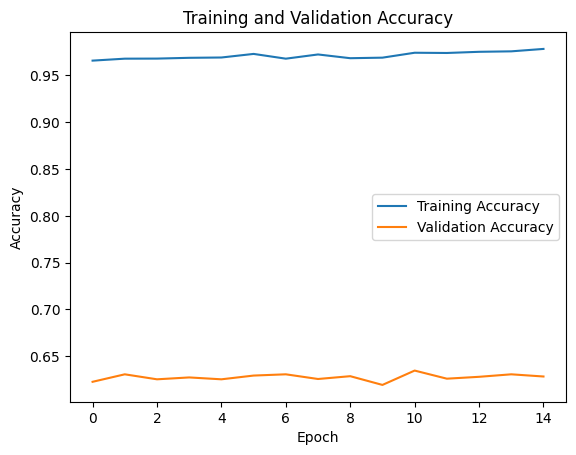

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

The model's validation accuracy of around 62.8% indicates that there is room for improvement. Several factors could contribute to this inaccuracy:

*   **Dataset Size and Variety:** While 15,000 images is a good starting point, the complexity of distinguishing between 30 classes of waste might require a larger and more diverse dataset. Variations in lighting, angles, and the state of the waste items can also impact performance.
*   **Class Imbalance:** Some classes in the dataset might have significantly more images than others. This can lead to the model being biased towards the majority classes and performing poorly on minority classes.
*   **Model Architecture Complexity:** The current lightweight CNN model, while suitable for edge deployment, might not be complex enough to capture the intricate features needed to differentiate between all 30 waste categories effectively. More complex architectures or pre-trained models might be necessary.
*   **Hyperparameters:** The chosen hyperparameters (e.g., learning rate, batch size, number of epochs) might not be optimal for this specific dataset and model architecture.
*   **Overfitting:** While the training accuracy is very high (around 97%), the validation accuracy is significantly lower. This suggests that the model might be overfitting to the training data and not generalizing well to unseen images. The lack of regularization and data augmentation in the initial training could contribute to this.
*   **Image Resolution and Quality:** The image size of 128x128 pixels might be too low to preserve enough detail for accurate classification of some waste items, especially those with subtle differences.
*   **Labeling Errors:** Inaccurate labels in the dataset can also lead to the model learning incorrect associations.

To improve the model's accuracy, we can explore strategies such as data augmentation, trying different model architectures, hyperparameter tuning, and utilizing transfer learning.